In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/masters

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/masters


In [1]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, get_data_sub_paths
from models.kangkang_fnn_models import KangFeedForwardNetwork, SimpleKangFNN
from dataloaders.flat_loader import FlatDataLoaders, MockLoader, MockLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, PerTimeStepPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics, save_metrics
from utils.mock_data import mock_fnn_data_classification
from utils.plots import im
from utils.utils import pshape
from trainers.generic_trainer import train_model
from models.kangkang_fnn_models import train_epoch_for_fnn
from utils.configs import BaseConf
from utils.metrics import best_threshold, get_y_pred
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup
%matplotlib inline
from utils.mock_data import mock_fnn_data_classification
import matplotlib.pyplot as plt
from pprint import pprint
from utils.plots import im
from utils.metrics import best_threshold, get_y_pred, get_y_pred_by_thresholds, best_thresholds
from models.model_result import ModelResult, ModelMetrics, save_metrics, compare_models,\
                                get_models_metrics, get_models_results
from models.baseline_models import ExponentialMovingAverage, UniformMovingAverage, \
                                    TriangularMovingAverage, HistoricAverage

In [2]:
class GRUFNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUFNN, self).__init__()

        self.name = "GRUFNN"

        self.gru = nn.GRU(input_size, hidden_size, num_layers)  # (seq_len, batch_size, n_features) format
        self.lin1 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x, h0=None):
        # Forward propagate RNN
        if h0 is not None:
            out, hn = self.gru(x, h0)
        else:
            out, hn = self.gru(x)
        out = self.relu(out)
        out = self.lin1(out)
        out = self.relu(out)

        return out  

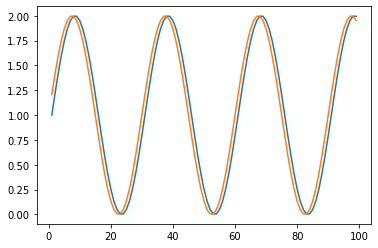

In [3]:
x = np.arange(100)
y = 1+ np.sin(2*np.pi*x/30) #+ np.sin(2*np.pi*x/100)
t = np.copy(y)
t = t[1:]
y = y[:-1]
x = x[1:]
plt.plot(x,y)
plt.plot(x,t)

y = np.expand_dims(y,-1)
y = np.expand_dims(y,-1)


t = np.expand_dims(t,-1)
t = np.expand_dims(t,-1)

In [4]:
inp = torch.Tensor(y)
trg = torch.Tensor(t)

criterion = nn.MSELoss()


model = GRUFNN(input_size=1, hidden_size=10, output_size=1)  # seq_len, batch_size, 
parameters = model.parameters()
optimiser = optim.Adam(params=parameters,
                       lr=1e-3,
                       weight_decay=0)
out = model(inp)


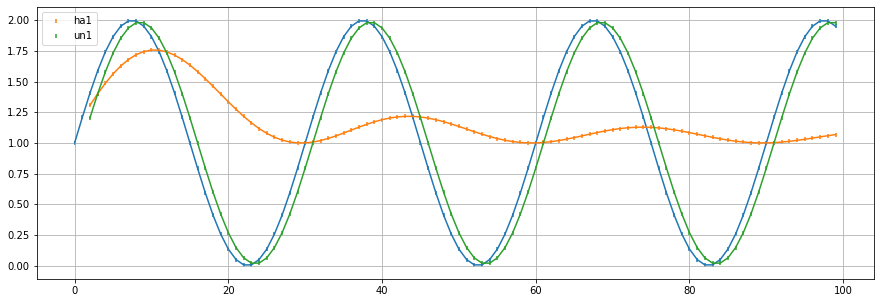

In [5]:
x = np.arange(100)
y = 1+ np.sin(2*np.pi*x/30) #+ np.sin(2*np.pi*x/100)
plt.figure(figsize=(15,5))
plt.plot(x,y)
plt.scatter(x,y,s=10,marker='|')
plt.grid()
for time_step in [1]:
    uno = UniformMovingAverage(window_len=3)
    ha = HistoricAverage(step=time_step)
    o = ha(y)
    plt.plot(x,o)
    plt.scatter(x,o,s=10,marker='|',label="ha"+str(time_step))
    
    o = uno(y)
    plt.plot(x,o)
    plt.scatter(x,o,s=10,marker='|',label="un"+str(time_step))

plt.legend()
plt.show()

#### Ensure data_group for the grid and the . flat dataset are both working with the same data and same shaper and same dates

In [6]:
data_sub_paths = get_data_sub_paths()
np.sort(data_sub_paths)

array(['T12H-X850M-Y880M_2013-01-01_2015-01-01',
       'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
       'T1H-X850M-Y880M_2013-01-01_2015-01-01',
       'T24H-X255M-Y220M_2013-01-01_2015-01-01',
       'T24H-X425M-Y440M_2013-01-01_2015-01-01',
       'T24H-X850M-Y880M_2013-01-01_2015-01-01',
       'T24H-X85M-Y110M_2013-01-01_2015-01-01',
       'T3H-X850M-Y880M_2013-01-01_2015-01-01',
       'T6H-X850M-Y880M_2013-01-01_2015-01-01'], dtype='<U39')

In [374]:
data_sub_paths = get_data_sub_paths()
pprint(np.sort(data_sub_paths))
data_sub_path = 'T24H-X425M-Y440M_2013-01-01_2015-01-01'

array(['T12H-X850M-Y880M_2013-01-01_2015-01-01',
       'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
       'T1H-X850M-Y880M_2013-01-01_2015-01-01',
       'T24H-X255M-Y220M_2013-01-01_2015-01-01',
       'T24H-X425M-Y440M_2013-01-01_2015-01-01',
       'T24H-X850M-Y880M_2013-01-01_2015-01-01',
       'T24H-X85M-Y110M_2013-01-01_2015-01-01',
       'T3H-X850M-Y880M_2013-01-01_2015-01-01',
       'T6H-X850M-Y880M_2013-01-01_2015-01-01'], dtype='<U39')


In [375]:
conf = BaseConf()
conf.data_path = f"./data/processed/{data_sub_path}/"
conf.model_name = "dev-model"
conf.model_path = f"{conf.data_path}models/{conf.model_name}"

flat_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
flat_loaders = FlatDataLoaders(data_group=flat_group, conf=conf)

# grid_group = GridDataGroup(data_path=conf.data_path, conf=conf)
# grid_loaders = GridDataLoaders(data_group=grid_group, conf=conf)

In [376]:
flat_group.crimes.shape

(729, 2, 2300)

In [377]:
# time step in this context is used for 
freqstr = flat_group.t_range.freqstr
if freqstr == "H":
    freqstr = "1H"
time_step = int(24 / int(freqstr[:freqstr.find("H")]))
time_step

1

In [378]:
data = flat_group.crimes
ha = HistoricAverage(step=time_step)
ha.fit(data)
print(ha.__dict__)

finding best max_steps parameter...
best max_steps -> 8
{'step': 1, 'max_steps': 8}


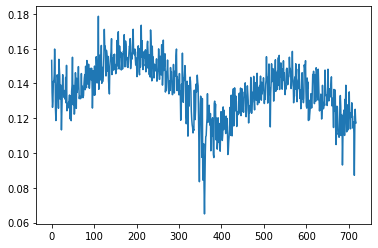

In [379]:
plt.plot(inpt.mean(-1)[10:1000])


In [380]:
inpt = np.copy(flat_group.crimes[:,0])
trgs = np.copy(inpt)
trgs = trgs[1:]
inpt = inpt[:-1]

tst_len = int(0.3*len(inpt))

results = {}
for step in [1]:
    for max_steps in range(1,37):
        ha = HistoricAverage(step=step,max_steps=max_steps)
        out = ha(inpt)
        
        mae = np.mean(np.abs(trgs[tst_len:]-out[tst_len:]))
        results[mae] = max_steps
        print(mae,max_steps)

0.07507306516136167 1
0.07331709160295118 2
0.07277231797712717 3
0.07255597767947396 4
0.0724591066612956 5
0.07233845365681581 6
0.07226153805411518 7
0.07224703033260722 8
0.07225609694711188 9
0.07227854394288011 10
0.07229155161133914 11
0.07229514176860069 12
0.0722821200139966 13
0.07225711660884979 14
0.07226076994853374 15
0.07227341494380424 16
0.07229896694795952 17
0.07232029067433847 18
0.07233293125824998 19
0.07233960576396826 20
0.07233658182571488 21
0.0723411887988628 22
0.07235669583698584 23
0.07237057619248646 24
0.07239247449963977 25
0.0723989203432611 26
0.07240425420265713 27
0.07240331796621444 28
0.07240753299721449 29
0.07241642692886668 30
0.07243236375250563 31
0.07244849312443576 32
0.07245845146735447 33
0.07246406692519207 34
0.07246318791579415 35
0.07247040664374399 36


best param: 8


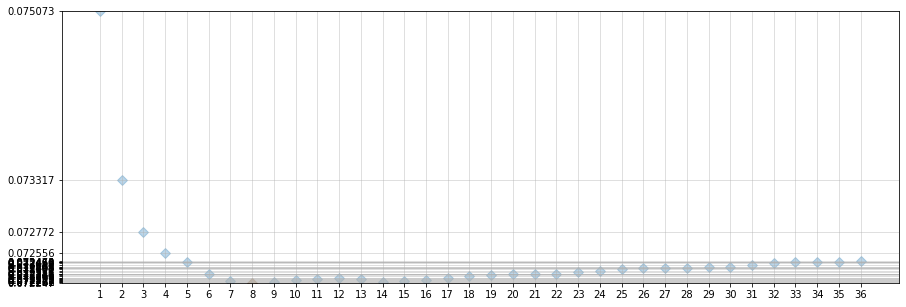

In [381]:
score, param = np.array(list(results.keys())), np.array(list(results.values()))
plt.figure(figsize=(15,5))
plt.scatter(param, score,s=50,marker="D",alpha=.3)
best_arg = np.argmin(score)
print("best param:",param[best_arg])
plt.scatter(param[best_arg], score[best_arg],s=50,marker="D",alpha=.3)
plt.ylim(np.min(score),np.max(score))
plt.xticks(param)
plt.yticks(score)
plt.grid(True,alpha=.5)

In [ ]:
im(grid_group.crimes.mean(0))

# mock data ensures the models work as they should

In [0]:
# compare results and new thresh per cell vs original metric
metrics = get_models_metrics(conf.data_path)
results = get_models_results(conf.data_path)

In [0]:
probas_pred = results[0].probas_pred
y_pred = results[0].y_pred
y_true = results[0].y_true

In [0]:
thresholds = best_thresholds(y_true=y_true,
                             probas_pred=probas_pred)
best_t = best_threshold(y_true=y_true,
                             probas_pred=probas_pred)


In [0]:
t = y_true.sum(0)[0]


In [0]:
def norm(x):
    x -= x.min()
    x /= x.max()
    return x

In [0]:
model_metrics = ModelMetrics(model_name=conf.model_name,
                             y_true=y_true,
                             y_pred=y_pred_new,
                             probas_pred=probas_pred)

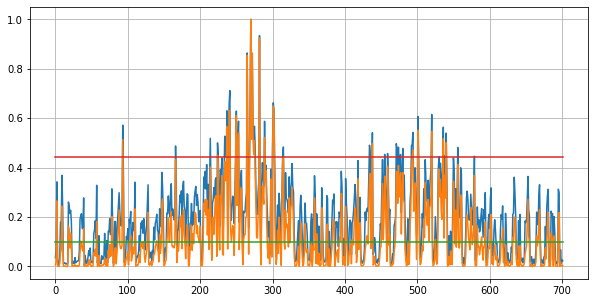

In [0]:
plt.figure(figsize=(10,5))
plt.plot(norm(thresholds))
# plt.plot(norm(t))
plt.plot(norm(norm(t)*norm(thresholds)))
plt.plot(np.ones_like(thresholds)*best_t)
mean = np.mean(norm(t))
plt.plot(np.ones_like(thresholds)*mean)
plt.grid()
plt.show()

In [0]:

class0_args = np.zeros(10)
class1_args = np.ones(10)
a = np.arange(10)#np.array(list(zip(class0_args, class1_args))).flatten()
print(a)
np.random.shuffle(a)
print(a)

[0 1 2 3 4 5 6 7 8 9]
[3 0 6 7 9 2 4 8 1 5]


In [0]:
# ensure all model weights are parameters

In [0]:
# Kang FNN



In [0]:
# ResNet


In [0]:
# ResNet-Extra

In [0]:
# Kang RNN

In [0]:
grid_group.shaper.l, flat_group.shaper.l

(702, 702)

In [0]:
def f(*xx):
    for y in xx:        
        x = y.testing_set.t_range
        print("tst: ",len(x), x[0]," -> ",x[-1],y.testing_set.target_shape)
    print()    
    for y in xx:          
        x = y.validation_set.t_range
        print("val: ",len(x), x[0]," -> ",x[-1],y.validation_set.target_shape)
    print()
    for y in xx:          
        x = y.training_set.t_range
        print("trn: ",len(x), x[0]," -> ",x[-1],'\t',y.training_set.target_shape)
    print()

f(grid_group, flat_group)

tst:  121 2014-09-03 00:00:00  ->  2015-01-01 00:00:00 [99, 47, 33]
tst:  466 2013-09-23 00:00:00  ->  2015-01-01 00:00:00 [99, 1, 702]

val:  54 2014-01-13 00:00:00  ->  2014-03-07 00:00:00 [33, 47, 33]
val:  399 2013-02-02 00:00:00  ->  2014-03-07 00:00:00 [33, 1, 702]

trn:  221 2014-02-15 00:00:00  ->  2014-09-23 00:00:00 	 [200, 47, 33]
trn:  566 2013-03-07 00:00:00  ->  2014-09-23 00:00:00 	 [200, 1, 702]



In [0]:
grid_group.training_set.target_shape

[200, 47, 33]

In [0]:
(365-30)*0.3

100.5

In [0]:
data_path

'./data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/'

------

In [0]:
# plot the per time metrics for data folders
start_date = "2013-01-01"
end_date = "2015-01-01" 

data_dim_str = "T24H-X850M-Y880M"  #"T1H-X1700M-Y1760M"  # needs to exist
data_path = f"./data/processed/{data_dim_str}_{start_date}_{end_date}/"
# metrics = get_models_metrics(data_path)

In [0]:
list(map(lambda x: plt.plot(), metrics))

['Historic Average',
 'Hawkes General Model',
 'Previous Time Step',
 'Ind-Hawkes Model',
 'Rolling Average',
 'Global Average']

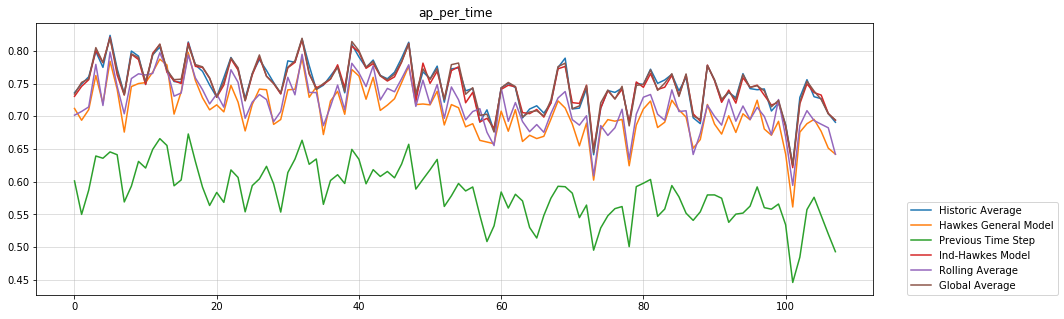

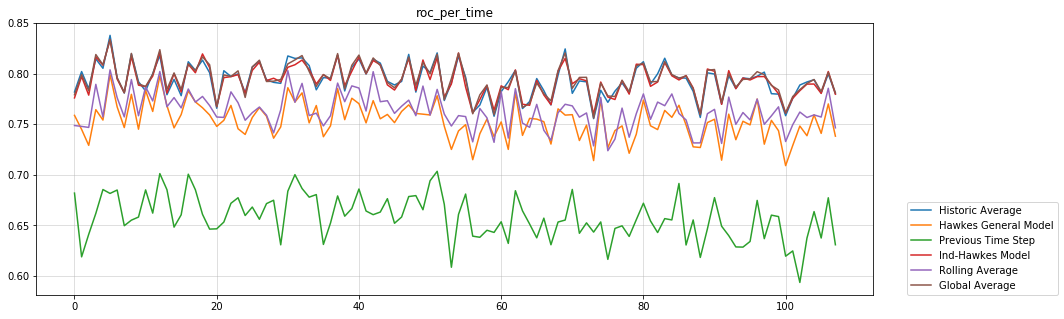

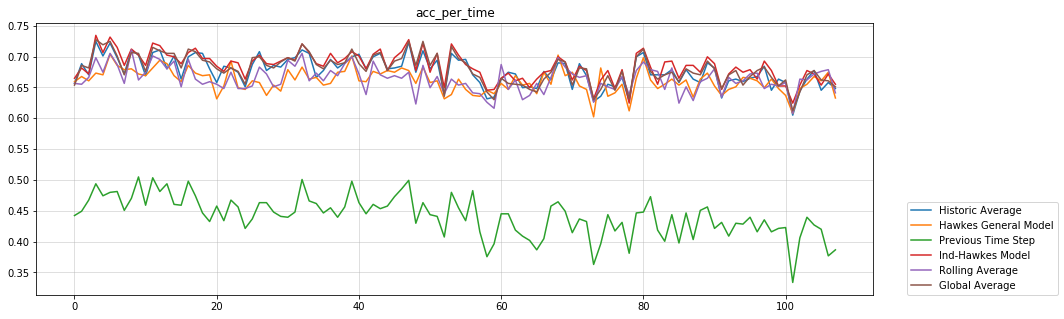

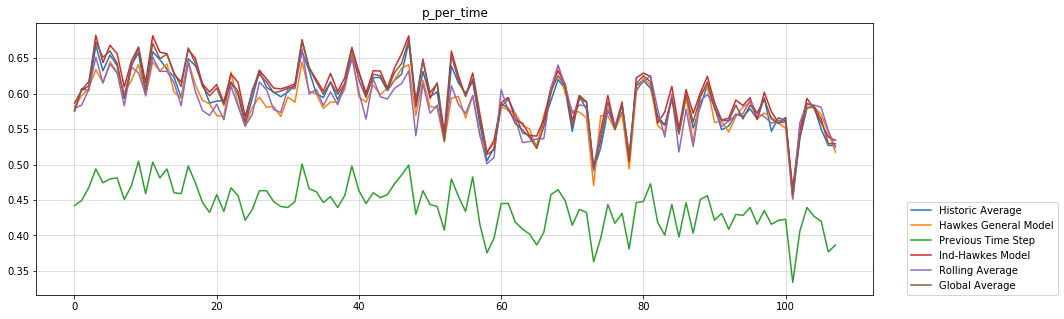

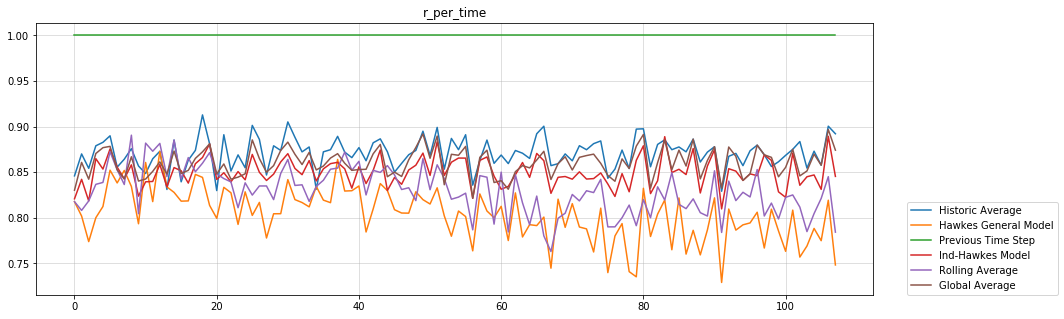

In [0]:
data_group  

In [0]:
conf = BaseConf()

data_group = FlatDataGroup(data_path=data_path, conf=conf)
loaders = FlatDataLoaders(data_group=data_group, conf=conf)

NameError: name 'conf' is not defined

In [0]:
start_date = "2013-01-01"
end_date = "2015-01-01" 

data_dim_str = "T24H-X850M-Y880M"  #"T1H-X1700M-Y1760M"  # needs to exist
model_name = "NOTE-BOOK-MODEL"  # needs to be created
data_path = f"./data/processed/{data_dim_str}_{start_date}_{end_date}/"

if not os.path.exists(data_path):
    raise Exception(f"Directory ({data_path}) needs to exist.")

model_path = data_path + f"models/{model_name}/"
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")

timer = Timer()
# manually set the config
# manually set the config
conf_dict = {
    "seed": 3,
    "use_cuda": True,
    
    "use_crime_types": False,
    
    # data group/data set related
    "val_ratio": 0.1,  # ratio of the total dataset
    "tst_ratio": 0.3,# ratio of the total dataset
    "seq_len": 1,
    "flatten_grid": True,  # if the shaper should be used to squeeze the data
    
    # shaper related 
    "shaper_top_k": -1,  # if less then 0, top_k will not be applied
    "shaper_threshold": 0,

    
    # data loader related
    "sub_sample_train_set": 1,
    "sub_sample_validation_set": 1,
    "sub_sample_validation_set": 0,
    
    # training parameters
    "resume": False,
    "early_stopping": False,
    "tolerance": 1e-8,
    "lr": 1e-3,
    "weight_decay": 1e-8,
    "max_epochs": 1,
    "batch_size": 64,
    "dropout": 0.2,
    "shuffle": False,
    "num_workers": 6,
    
    # attached global variables - bad practice -find alternative
    "device": None,  # pytorch device object [CPU|GPU]
    "timer": Timer(),
    "model_name": model_name,
    "model_path": model_path,
    "checkpoint": "best",
    
    "use_seq_loss": True,
}
conf = BaseConf(conf_dict=conf_dict)

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed( conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type
conf.device = device

2019-11-03T11:35:19 | root | INFO | =====================================BEGIN=====================================
2019-11-03T11:35:19 | root | INFO | Device: cpu


In [0]:
conf.sub_sample_test_set = False
conf.sub_sample_train_set = True
conf.sub_sample_validation_set = True

data_group = FlatDataGroup(data_path=data_path, conf=conf)
loaders = FlatDataLoaders(data_group=data_group, conf=conf)

2019-11-03T11:35:21 | root | INFO | 	t_range shape (731,)


In [0]:
pshape(data_group.crimes,
       data_group.training_set.crimes,
       data_group.testing_set.crimes,
       data_group.validation_set.crimes)

(729, 2, 9043)
(585, 2, 9043)
(474, 2, 9043)
(402, 2, 9043)


In [0]:
N,L = 10, 10

np.arange(N*L).reshape(N,1,L)

array([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9]],

       [[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]],

       [[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]],

       [[30, 31, 32, 33, 34, 35, 36, 37, 38, 39]],

       [[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]],

       [[50, 51, 52, 53, 54, 55, 56, 57, 58, 59]],

       [[60, 61, 62, 63, 64, 65, 66, 67, 68, 69]],

       [[70, 71, 72, 73, 74, 75, 76, 77, 78, 79]],

       [[80, 81, 82, 83, 84, 85, 86, 87, 88, 89]],

       [[90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]])